## Imports

In [1]:
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from collections import defaultdict
import pickle
from timeit import default_timer as timer
from typing import Callable, Dict

from huggingface_hub import notebook_login
import fasttext
import joblib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import torch
import transformers
from tqdm.notebook import tqdm

from jjuoda_dl4 import preprocessing, utils

FIGURES_DIR = utils.BASE_FIGURES_DIR / "evaluation"

sns.set_context("talk")

In [3]:
fasttext_model = fasttext.load_model(str(utils.BASE_MODEL_DIR / "cc.en.300.bin"))

In [4]:
fake_and_real_news = pd.read_csv(utils.BASE_DATA_DIR / "final/merged.csv")
fake_and_real_news.fillna("", inplace=True)
nela_gt_2018 = pd.read_csv(utils.BASE_DATA_DIR / "final/nela_gt_2018.csv", index_col=0)
fake_news_content_detection = pd.read_csv(
    utils.BASE_DATA_DIR / "final/fake_news_content_detection.csv"
)
fake_news_content_detection.dropna(inplace=True)
nela_gt_2018_val = nela_gt_2018[nela_gt_2018.split == "val"]

In [5]:
datasets = {
    "fake_and_real_news": fake_and_real_news,
    "fake_news_content_detection": fake_news_content_detection,
    "nela_gt_2018_val": nela_gt_2018_val,
}

In [6]:
labels = {name: datasets[name].is_fake for name in datasets}

In [7]:
encodings = {}
for name, dataset in datasets.items():
    encodings[name] = preprocessing.encode_articles(dataset, fasttext_model)

In [8]:
with open(utils.BASE_MODEL_DIR / "tfidf_title.pk", "rb") as f:
    tfidf_title_vectorizer = pickle.load(f)

with open(utils.BASE_MODEL_DIR / "tfidf_text.pk", "rb") as f:
    tfidf_text_vectorizer = pickle.load(f)

In [9]:
tfidf_vectors = {
    name: preprocessing.get_tfidf_vectors(
        datasets[name], tfidf_title_vectorizer, tfidf_text_vectorizer
    )
    for name in datasets
}

In [10]:
encodings_with_tfidf = {
    name: np.concatenate([encodings[name], tfidf_vectors[name]], axis=1)
    for name in datasets
}

Due to the way I'm picking threshold, accuracy on Nela dataset is going to be optimistic.

## Helper functions

In [11]:
def pick_threshold(y_true, pred_proba):
    """Pick a threshold maximizing trade-off between sensitivity and specificity."""
    y_true = y_true.astype(int)
    fpr, tpr, thresholds = roc_curve(y_true, pred_proba)
    youdens_j = tpr - fpr
    return thresholds[np.argmax(youdens_j)]

In [12]:
def _calculate_auc_acc(y_true, pred_proba, threshold):
    """Calculate AUC and accuracy."""
    y_true = y_true.astype(int)
    auc = roc_auc_score(y_true, pred_proba)
    acc = accuracy_score(y_true, pred_proba > threshold)
    return auc, acc

In [13]:
def get_metrics(
    features: Dict[str, np.ndarray],
    labels: Dict[str, np.ndarray],
    cb_pred_proba: Callable[[np.ndarray], np.ndarray],
) -> Dict[str, Dict[str, float]]:
    """Calculate auc and accuracy for each feature set.

    Args:
        features (Dict[str, np.ndarray]): features in form of
            {"nela_gt_2018_val": nela_features, ...}
        labels (Dict[str, np.ndarray]): labels in form of
            {"nela_gt_2018_val": nela_features, ...}
        cb_pred_proba (Callable[[np.ndarray], np.ndarray]): function taking features
            and returning class probabilities

    Returns:
        Dict[str, Dict[str, float]]: metrics in form
            {"train": {"auc": train_auc, "accuracy": train_accuracy}, ...}
    """
    assert len(features) == len(labels)
    for name in labels:
        labels[name] = labels[name].astype(int)
    nela_val = "nela_gt_2018_val"

    nela_features = features[nela_val]
    nela_labels = labels[nela_val]
    nela_probas = cb_pred_proba(nela_features)
    threshold = pick_threshold(nela_labels, nela_probas)
    auc, acc = _calculate_auc_acc(nela_labels, nela_probas, threshold)
    yield {"dataset": "nela_gt_2018_val", "auc": auc, "accuracy": acc}

    for name, values in features.items():
        if name == nela_val:
            continue
        preds = cb_pred_proba(values)
        start = timer()
        cb_pred_proba(values[0].reshape(1, -1))
        end = timer()
        auc, acc = _calculate_auc_acc(labels[name], preds, threshold)
        yield {"dataset": name, "auc": auc, "accuracy": acc, "latency": end - start}

In [14]:
raise RuntimeError("Stop, results are already calculated.")

RuntimeError: Stop, results are already calculated.

## Metric calculation for models

### Linear models

In [ ]:
results = []

In [ ]:
with open(utils.BASE_MODEL_DIR / "logistic_regression.pk", "rb") as f:
    logistic_regression_model = pickle.load(f)

# I'm just taking result I got on a val split for logistic regression in modelling.ipynb
# Logistic regression was actually trained on Fake and Real News dataset, so I cannot
# calculate metrics looking at its performance on whole dataset
# Other models did not see Fake and Real News dataset during training
results.append(
    {
        "model": "logistic_regression",
        "dataset": "fake_and_real_news",
        "auc": 0.8933100371912057,
        "accuracy": 0.9328358208955224,
    }
)

In [ ]:
for metrics in get_metrics(
    features={
        "nela_gt_2018_val": encodings["nela_gt_2018_val"][:, 300:],
        "fake_news_content_detection": encodings["fake_news_content_detection"][
            :, 300:
        ],
    },
    labels={
        "nela_gt_2018_val": labels["nela_gt_2018_val"],
        "fake_news_content_detection": labels["fake_news_content_detection"],
    },
    cb_pred_proba=lambda x: logistic_regression_model.predict_proba(x)[:, 1],
):
    metrics["model"] = "logistic_regression"
    results.append(metrics)

In [ ]:
del logistic_regression_model

### Gradient boosted trees

In [ ]:
with open(utils.BASE_MODEL_DIR / "lightgbm_simple.pk", "rb") as f:
    lightgbm_simple = pickle.load(f)

with open(utils.BASE_MODEL_DIR / "lightgbm_with_tfidf.pk", "rb") as f:
    lightgbm_tfidf = pickle.load(f)

In [ ]:
for metrics in get_metrics(encodings, labels, lightgbm_simple.predict):
    metrics["model"] = "lightgbm_simple"
    results.append(metrics)

In [ ]:
for metrics in get_metrics(encodings_with_tfidf, labels, lightgbm_tfidf.predict):
    metrics["model"] = "lightgbm_with_tfidf"
    results.append(metrics)

In [ ]:
del lightgbm_simple, lightgbm_tfidf

### KNNs

In [ ]:
knn_cosine_NA_simple = joblib.load(
    utils.BASE_MODEL_DIR / "knn_classifier_NoneType_cosine.pkl"
)
with joblib.parallel_backend("threading"):
    for metrics in get_metrics(
        encodings, labels, lambda x: knn_cosine_NA_simple.predict_proba(x)[:, 1]
    ):
        metrics["model"] = "knn_cosine_NA_simple"
        results.append(metrics)

del knn_cosine_NA_simple

In [ ]:
knn_cosine_smote_simple_128 = joblib.load(
    utils.BASE_MODEL_DIR / "knn_classifier_SMOTE_cosine.pkl"
)
knn_cosine_smote_simple_128.n_neighbors = 128

with joblib.parallel_backend("threading", n_jobs=-1):
    for metrics in get_metrics(
        encodings, labels, lambda x: knn_cosine_smote_simple_128.predict_proba(x)[:, 1]
    ):
        metrics["model"] = "knn_cosine_smote_simple_128"
        results.append(metrics)

del knn_cosine_smote_simple_128

In [ ]:
# I'm doing all this ofloading to disk due to ram issues
results_classical_df = pd.DataFrame(results)
results_classical_df.to_csv(utils.BASE_DATA_DIR / "processed" / "results_classical.csv")
del encodings
del tfidf_vectors
del encodings_with_tfidf

NameError: name 'tfidf_vectors' is not defined

In [34]:
raise RuntimeError("Stop, results are already calculated.")

RuntimeError: Stop, results are already calculated.

### AutoNLP

First of all - can Nela gt 2018 val split be used for evaluation?
I trained on a some nela data and after that I've increased and training data size and changed validation articles. If I'm lucky, models didn't see my current validation articles in their training.

In [10]:
deep_results = []

In [11]:
autonlp_train_data = pd.read_csv(
    utils.BASE_DATA_DIR / "interim/train_articles.csv", index_col=0
)

In [12]:
titles = autonlp_train_data.combined_text.str.replace(
    r"\<TITLE\>(.*)\</TITLE\>", r"\1", regex=True
)

In [13]:
set(nela_gt_2018_val.title.str.lower()).intersection(set(titles.str.lower()))

set()

Aight, I'm lucky and AutoNLP models didn't see any of the articles in validation set.

In [14]:
del autonlp_train_data

In [15]:
model_names = [
    "mutusfa/autonlp-Fake_News_Analysis-528914957",
    "mutusfa/autonlp-Fake_News_Analysis-528914958",
    "mutusfa/autonlp-Fake_News_Analysis-528914959",
    "mutusfa/autonlp-Fake_News_Analysis-528914960",
]

In [16]:
notebook_login()

In [34]:
def _get_preds_and_latency(model, tokenizer, dataset, device):
    preds = []
    torch_dataset = preprocessing.AutoNLPNELADataset(
        dataset,
        tokenizer,
    )
    dataloader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=32, shuffle=False, num_workers=8
    )

    preds = []
    for batch in dataloader:
        for k in batch["model_inputs"].keys():
            batch["model_inputs"][k] = batch["model_inputs"][k].to(device).squeeze(1)
        with torch.no_grad():
            preds.extend(
                torch.sigmoid(model(**batch["model_inputs"]).logits[:, 1])
                .detach()
                .cpu()
                .numpy()
            )

    start = timer()
    with torch.no_grad():
        sample = torch_dataset[0]
        for k in sample["model_inputs"]:
            sample["model_inputs"][k] = sample["model_inputs"][k].to(device)
        model(**sample["model_inputs"])
    latency = timer() - start

    return preds, latency


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_name in tqdm(model_names):
    model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_name, use_auth_token=True
    )
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_name, use_auth_token=True
    )

    model.eval()
    model.to(device)

    # We need to pick a threshold so I'm calculating nela separately
    print(f"Working on nela")
    nela_preds, nela_latency = _get_preds_and_latency(
        model, tokenizer, datasets["nela_gt_2018_val"], device
    )
    threshold = pick_threshold(labels["nela_gt_2018_val"], nela_preds)
    nela_auc, nela_acc = _calculate_auc_acc(
        labels["nela_gt_2018_val"], nela_preds, threshold
    )
    deep_results.append(
        {
            "model": model_name,
            "dataset": "nela_gt_2018_val",
            "auc": nela_auc,
            "accuracy": nela_acc,
            "latency": nela_latency,
        }
    )

    for name in datasets:
        if name == "nela_gt_2018_val":
            continue
        print(f"Working on {name}")
        preds, latency = _get_preds_and_latency(
            model, tokenizer, datasets[name], device
        )
        threshold = pick_threshold(labels[name], preds)
        auc, acc = _calculate_auc_acc(labels[name], preds, threshold)
        deep_results.append(
            {
                "model": model_name,
                "dataset": name,
                "auc": auc,
                "accuracy": acc,
                "latency": latency,
            }
        )

  0%|          | 0/4 [00:00<?, ?it/s]

Working on nela
Working on fake_and_real_news
Working on fake_news_content_detection
Working on nela
Working on fake_and_real_news
Working on fake_news_content_detection
Working on nela
Working on fake_and_real_news
Working on fake_news_content_detection
Working on nela
Working on fake_and_real_news
Working on fake_news_content_detection


### DistilBERT

In [13]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased"
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [14]:
class NELADataset(torch.utils.data.Dataset):
    def __init__(self, articles_df, tokenizer, root_dir=utils.BASE_DATA_DIR):
        self.articles_df = articles_df
        self.root_dir = root_dir
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.articles_df)

    def __getitem__(self, index):
        article = self.articles_df.iloc[index]
        if "text" in article.keys():
            text = article["text"]
        else:
            with open(self.root_dir / article.path, "r") as f:
                text = f.read()
        inputs = self.tokenizer(
            article.title,
            text,
            add_special_tokens=True,
            return_tensors="pt",
            padding="max_length",
            truncation="longest_first",
            # max_length=256,
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
        return inputs


class NelaModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def backbone_grad(self, value):
        for param in self.model.parameters():
            param.requires_grad = value
        for param in self.model.pre_classifier.parameters():
            param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def forward(self, **model_inputs):
        return self.model(**model_inputs)

    def _shared_step(self, batch, batch_idx):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        results = self._shared_step(batch, batch_idx)
        self.log("train_loss", results.loss.detach())
        return results

    def validation_step(self, batch, batch_idx):
        results = self._shared_step(batch, batch_idx)
        self.log("val_loss", results.loss.detach())
        self.log(
            "val_auc",
            auroc(
                torch.sigmoid(results.logits.detach()[:, 1]),
                batch["labels"],
                num_classes=2,
            ),
        )
        return results

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            params=[p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate,
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }


nela_model = NelaModel(model)

checkpoint = torch.load(
    utils.BASE_MODEL_DIR / "best/epoch=0-val_loss=0.44-val_auc=0.24.ckpt"
)
nela_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [20]:
def _get_preds_and_latency(model, tokenizer, dataset, device):
    preds = []
    torch_dataset = NELADataset(
        dataset,
        tokenizer,
    )
    dataloader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=32, shuffle=False, num_workers=8
    )

    preds = []
    for batch in dataloader:
        for k in batch.keys():
            batch[k] = batch[k].to(device)
        with torch.no_grad():
            preds.extend(
                torch.sigmoid(model(**batch).logits[:, 1]).detach().cpu().numpy()
            )

    start = timer()
    with torch.no_grad():
        sample = torch_dataset[0]
        for k in sample:
            sample[k] = sample[k].to(device).unsqueeze(0)
        model(**sample)
    latency = timer() - start

    return preds, latency


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nela_model.eval()
nela_model.to(device)

# We need to pick a threshold so I'm calculating nela separately
print(f"Working on nela")
nela_preds, nela_latency = _get_preds_and_latency(
    nela_model, tokenizer, datasets["nela_gt_2018_val"], device
)
threshold = pick_threshold(labels["nela_gt_2018_val"], nela_preds)
nela_auc, nela_acc = _calculate_auc_acc(
    labels["nela_gt_2018_val"], nela_preds, threshold
)
deep_results.append(
    {
        "model": "personal_distil_bert",
        "dataset": "nela_gt_2018_val",
        "auc": nela_auc,
        "accuracy": nela_acc,
        "latency": nela_latency,
    }
)

for name in datasets:
    if name == "nela_gt_2018_val":
        continue
    print(f"Working on {name}")
    preds, latency = _get_preds_and_latency(
        nela_model, tokenizer, datasets[name], device
    )
    threshold = pick_threshold(labels[name], preds)
    auc, acc = _calculate_auc_acc(labels[name], preds, threshold)
    deep_results.append(
        {
            "model": "personal_distil_bert",
            "dataset": name,
            "auc": auc,
            "accuracy": acc,
            "latency": latency,
        }
    )

Working on nela


/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tenso

Working on fake_and_real_news


/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)
/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tenso

Working on fake_news_content_detection


/tmp/ipykernel_3505040/259350601.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs["labels"] = torch.tensor(article.is_fake, dtype=int)


In [32]:
deep_results = pd.DataFrame(deep_results)

In [35]:
deep_results.to_csv(utils.BASE_DATA_DIR / "processed/results_deep.csv")

## Pretty plots

In [15]:
deep_results = pd.read_csv(
    utils.BASE_DATA_DIR / "processed/results_deep.csv", index_col=0
)
classical_results = pd.read_csv(
    utils.BASE_DATA_DIR / "processed/results_classical.csv", index_col=0
)

In [16]:
results = pd.concat([deep_results, classical_results])
results = pd.melt(
    results, id_vars=["model", "dataset"], var_name="metric", value_name="value"
)

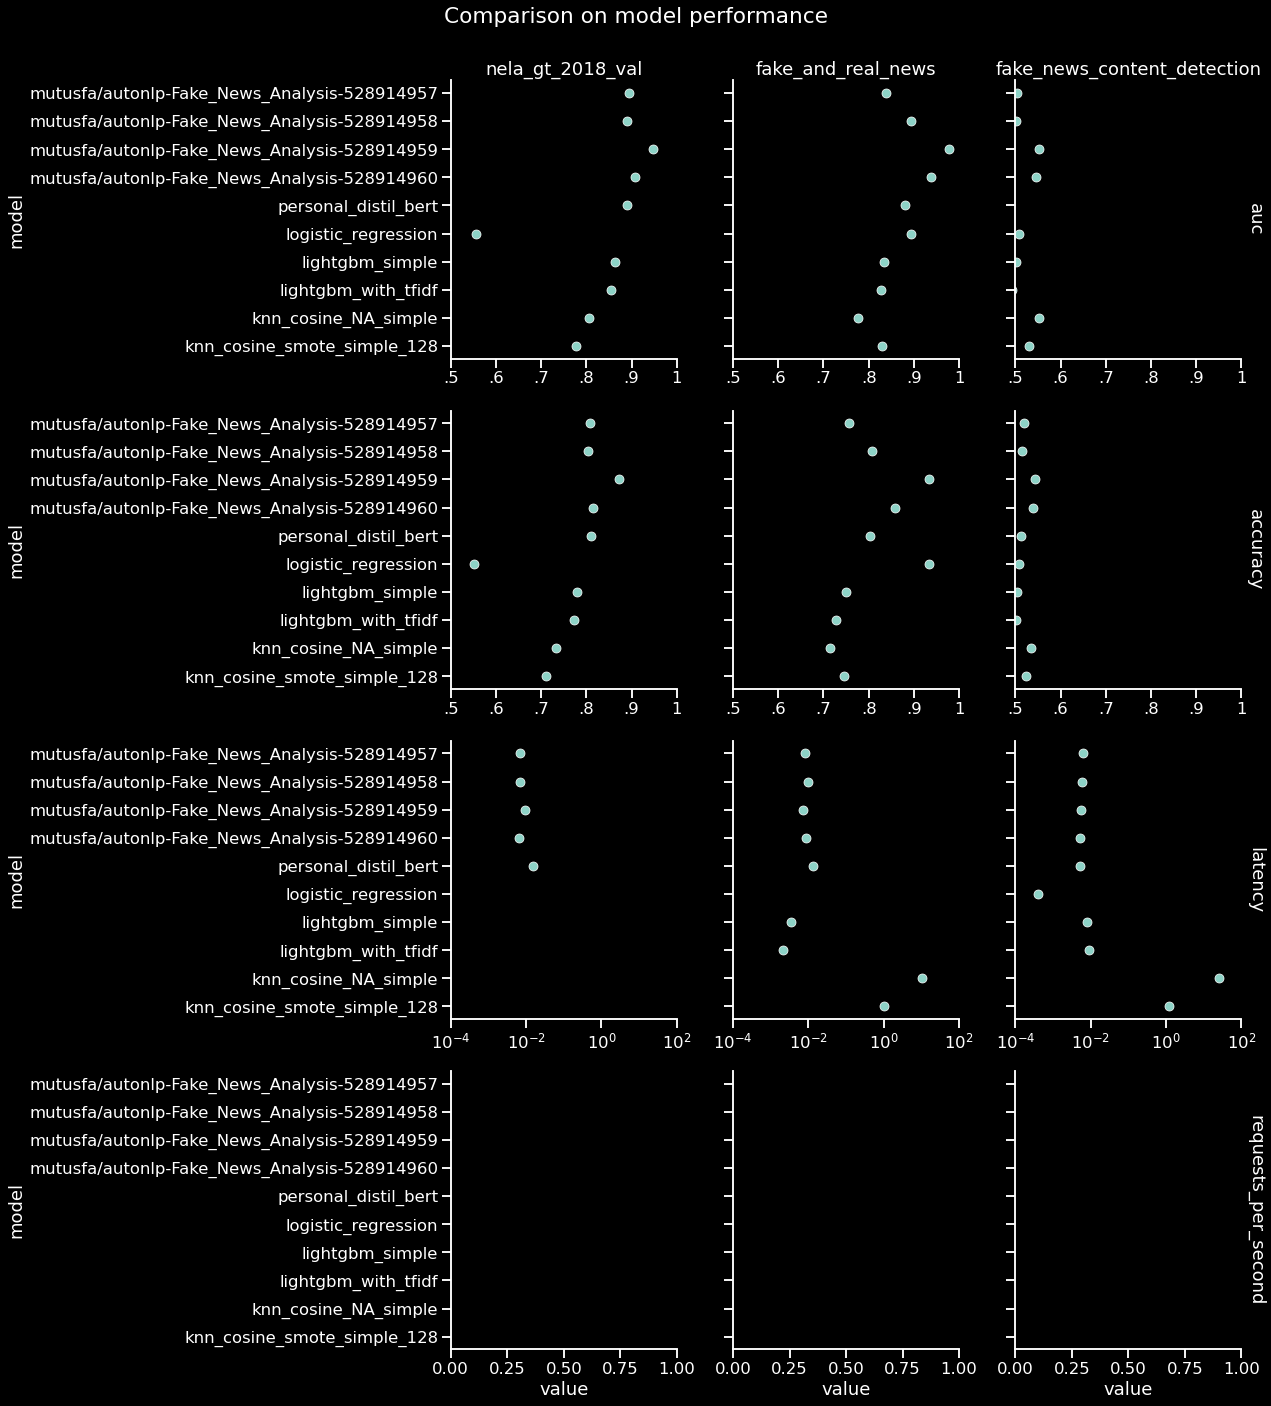

In [17]:
g = sns.relplot(
    data=results,
    y="model",
    x="value",
    row="metric",
    row_order=["auc", "accuracy", "latency", "requests_per_second"],
    col="dataset",
#    kind="bar",
    aspect=1.2,
    facet_kws={"sharey": True, "sharex": False, "margin_titles": True},
)

g.fig.suptitle(
     "Comparison on model performance\n"
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

axes = g.axes
for ax in axes.flat[:6]:
    ax.set_xlim(.5, 1)
    ax.set_xticks([.5, .6, .7, .8, .9, 1])
    ax.set_xticklabels([".5", ".6", ".7", ".8", ".9", "1"])

for ax in axes[2]:
    ax.set_xlim(1e-4, 1e2)
    ax.semilogx()

#plt.subplots_adjust(hspace=.2)
plt.tight_layout()

plt.savefig(FIGURES_DIR / "results_auc_scatter")

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (0,0)

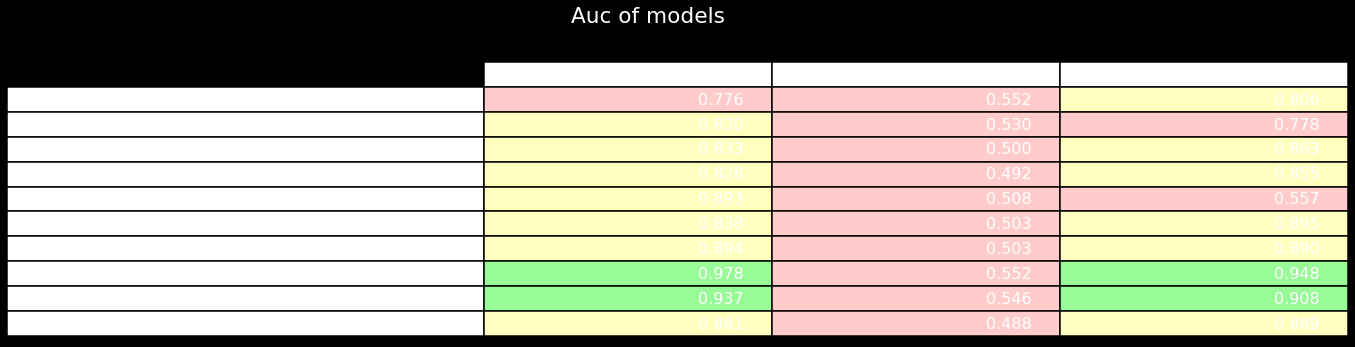

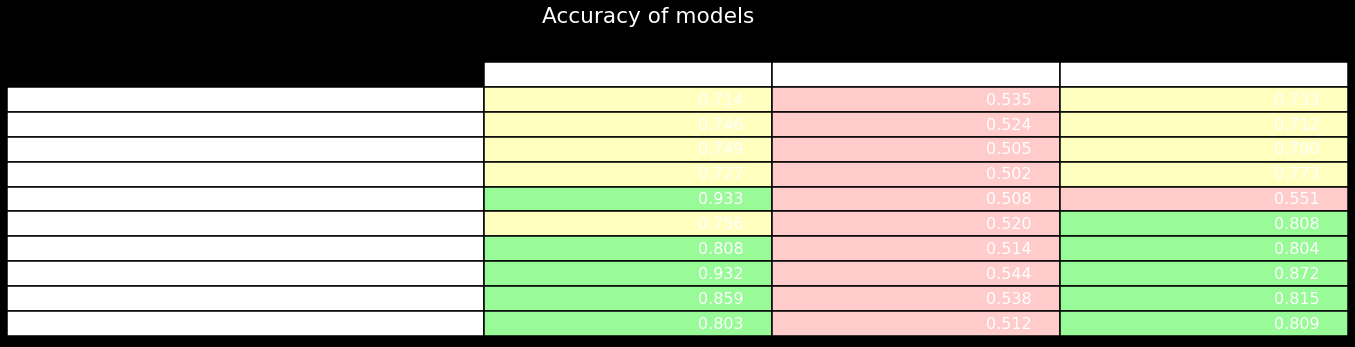

In [19]:
def _title(string):
    return string.capitalize().replace("_")

good_colour = [0x98 / 0xff, 0xFB / 0xff, 0x98 / 0xff]  # pale green
close_colour = [0xff /  0xff, 0xff / 0xff, 0xbf / 0xff]  # pale yellow
bad_color = [0xff / 0xff, 0xcc / 0xff, 0xcb / 0xff] # pale red

colour_map = {
    "auc": [.8, .9],
    "accuracy": [.7, .8],
    "requests_per_second": [50, 200],
}

for metric, (lower_close, lower_good) in colour_map.items():
    scores = results.loc[results.metric == metric, ["model", "dataset", "value"]]
    scores = scores.pivot_table(index="model", columns="dataset", values="value")
    
    colours_arr = np.array([[bad_color] * scores.shape[1]] * scores.shape[0])
    colours_arr[scores > lower_close] = close_colour
    colours_arr[scores > lower_good] = good_colour

    # Table data needs to be non-numeric text. Format the data
    # while I'm at it.
    cell_text = []
    for row in scores.values:
        cell_text.append([f'{x:.3f}' for x in row])

    plt.figure(figsize=(20, 5))
    plt.suptitle(f"{metric.capitalize()} of models")

    table = plt.table(
        cellText=cell_text,
        cellColours=colours_arr,
        colLabels=[name.capitalize().replace("_", " ") for name in datasets.keys()],
        rowLabels=scores.index,
        loc="center",
    )

    table.scale(1, 2)

    # hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # hide box of the axes
    plt.box(on=None)
    plt.tight_layout()

In [46]:
scores

dataset,fake_and_real_news,fake_news_content_detection,nela_gt_2018_val
model,,,
knn_cosine_NA_simple,0.775742,0.551734,0.806115
knn_cosine_smote_simple_128,0.829902,0.529768,0.777994
lightgbm_simple,0.832881,0.500417,0.862887
lightgbm_with_tfidf,0.827527,0.491680,0.855273
logistic_regression,0.893310,0.508235,0.556583
mutusfa/autonlp-Fake_News_Analysis-528914957,0.838041,0.503139,0.895311
mutusfa/autonlp-Fake_News_Analysis-528914958,0.894024,0.502598,0.890419
mutusfa/autonlp-Fake_News_Analysis-528914959,0.977637,0.552292,0.948234
mutusfa/autonlp-Fake_News_Analysis-528914960,0.936748,0.545590,0.908222


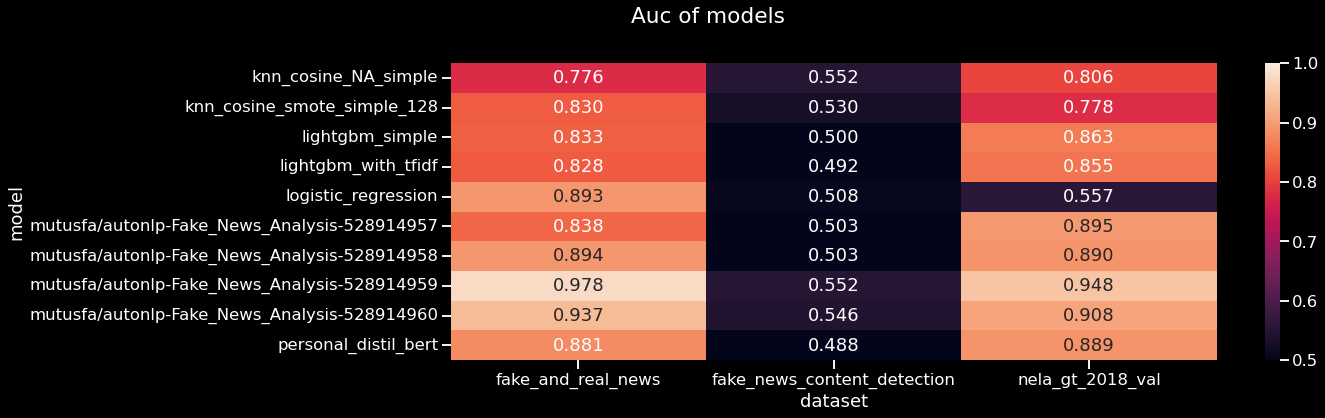

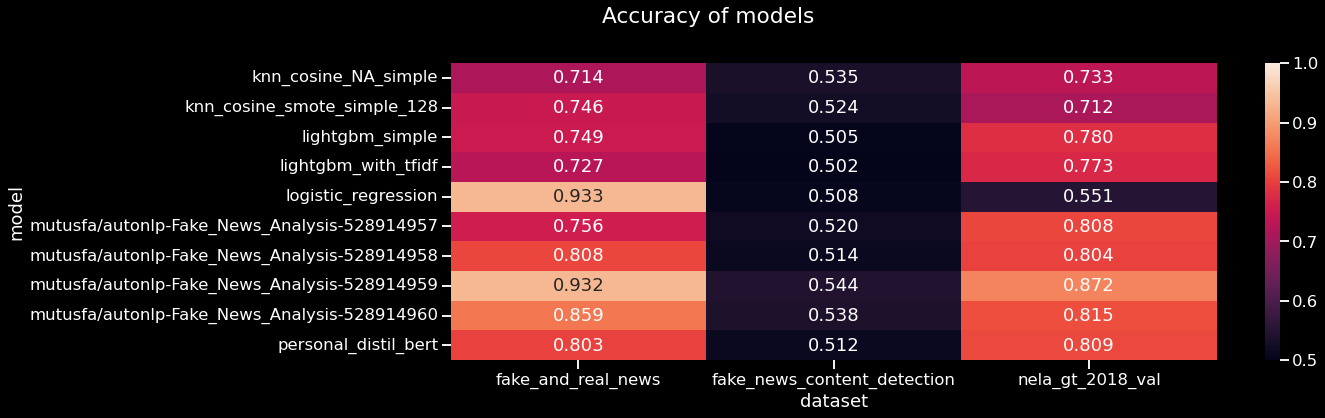

In [54]:
def _title(string):
    return string.capitalize().replace("_", " ")

good_colour = [0x98 / 0xff, 0xFB / 0xff, 0x98 / 0xff]  # pale green
close_colour = [0xff /  0xff, 0xff / 0xff, 0xbf / 0xff]  # pale yellow
bad_color = [0xff / 0xff, 0xcc / 0xff, 0xcb / 0xff] # pale red

min_max_table = {
    "auc": [.5, 1],
    "accuracy": [.5, 1],
    #"latency": [1e-4, 1e2],
}

for metric, (vmin, vmax) in min_max_table.items():

    scores = results.loc[results.metric == metric, ["model", "dataset", "value"]]
    scores = scores.pivot_table(index="model", columns="dataset", values="value")
    
    fig = plt.figure(figsize=(20, 6))
    plt.suptitle(f"{_title(metric)} of models")

    sns.heatmap(scores, annot=True, fmt=".3f", vmin=vmin, vmax=vmax)
    plt.tight_layout()

    plt.savefig(FIGURES_DIR / f"{metric}_heatmap.png", dpi=fig.dpi, pad_inches=10)